# Data Exploration and Processing

The dataset has 95 features, far too many to properly predict the target (if the company is bankrupt or not). Therefore, some data exploration and processing must be done in order to narrow down the dataset.

In [36]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from scipy.stats import shapiro

Ideas for feature reduction:
- Remove low variance features
- Remove features with low correlation to target
- Transform data into Gaussian and remove features that are still non-Gaussian

In [30]:
# Read data and separate into features and target
df = pd.read_csv('train_data.csv')
X_train = df.drop('Bankrupt?', axis=1)
y_train = df['Bankrupt?']

In [31]:
# Remove features where the variance is less than 0.001
var = X_train.var()
low_variance_cols = np.where(var < 0.001)[0].tolist()
high_variance_df = X_train.drop(X_train.columns[low_variance_cols], axis=1)

In [32]:
# Remove features with a low correlation to the target
correlations = df.corr()['Bankrupt?'].abs().sort_values(ascending=False)
correlations = correlations.drop('Bankrupt?')
high_correlation_cols = correlations.head(high_variance_df.shape[1])
high_correlation_cols = high_correlation_cols.index.tolist()
high_correlation_df = df.loc[:,high_correlation_cols]

In [33]:
# Resulting features are the intersection of the high variance and high correlation features
high_var_corr_cols = list(set(high_variance_df.columns.tolist()).intersection(set(high_correlation_df.columns.tolist())))
high_var_corr_df = X_train.loc[:,high_var_corr_cols]

In [34]:
# Transform all features into Gaussian, then drop features that are still not Gaussian
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df_qt = qt.fit_transform(high_var_corr_df)
high_var_corr_df = pd.DataFrame(df_qt, columns=high_var_corr_df.columns)

cols_to_drop = []
for i in high_var_corr_df.columns:
    stat, p = shapiro(high_var_corr_df.loc[:,i])
    if stat < 0.9:
        cols_to_drop.append(i)

print(f'Columns being dropped: {cols_to_drop}')
high_var_corr_df = high_var_corr_df.drop(columns=cols_to_drop)

# Add bankrupt column back
high_var_corr_df.insert(0, 'Bankrupt?', y_train)

Columns being dropped: [' Liability-Assets Flag', ' Tax rate (A)']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5807.
  res = hypotest_fun_out(*samples, **kwds)


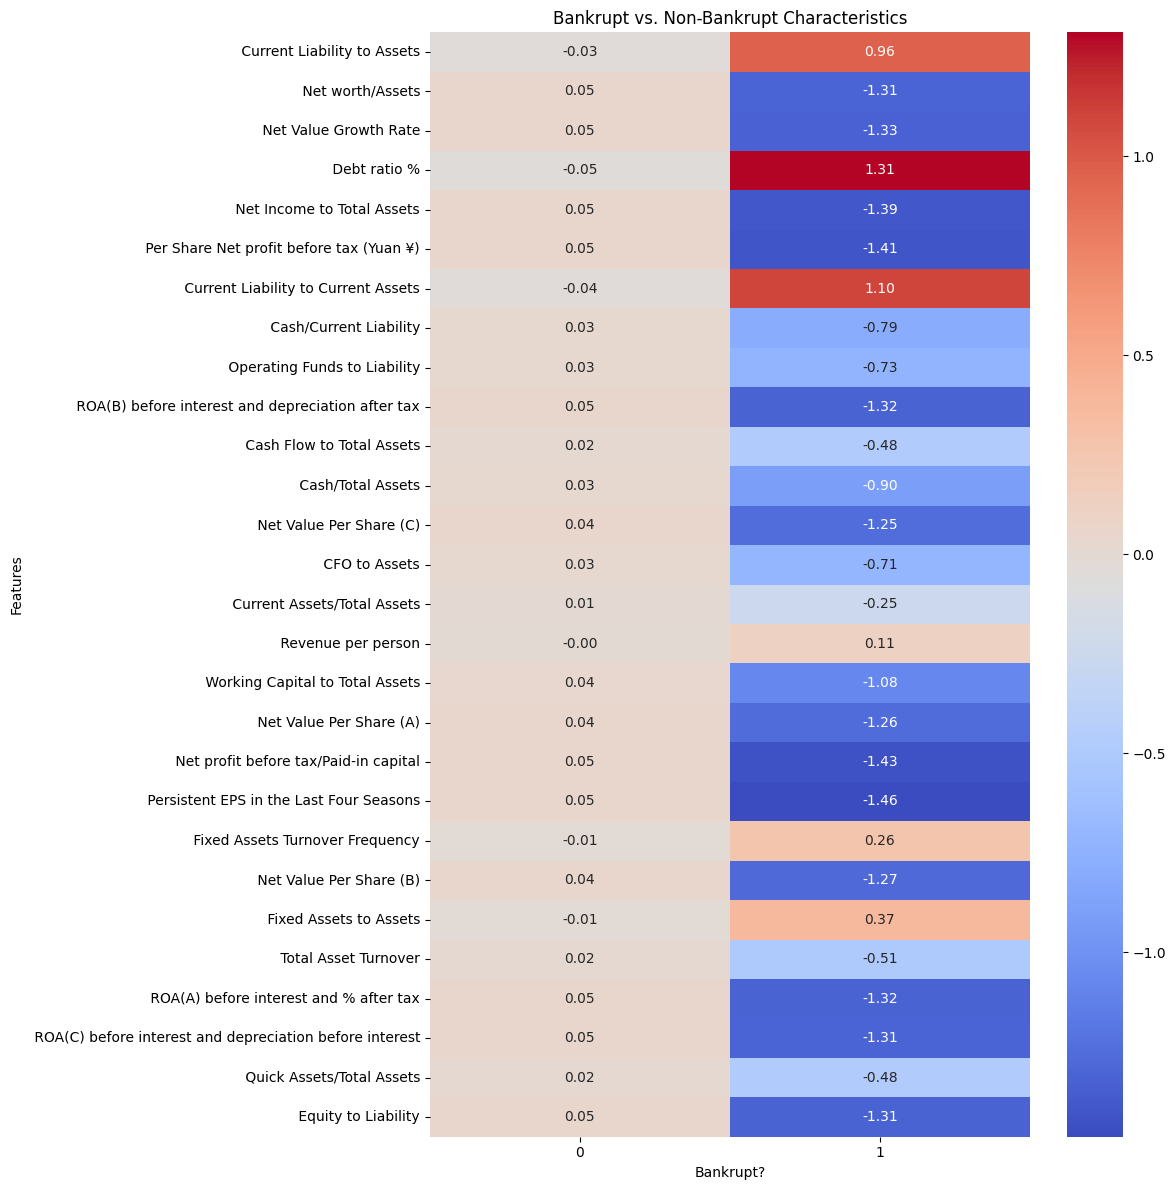

In [35]:
# Visualize characteristics of bankrupt and non-bankrupt companies
df_mean = high_var_corr_df.groupby('Bankrupt?').mean()
plt.figure(figsize=(12, 12))
sns.heatmap(df_mean.T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Bankrupt vs. Non-Bankrupt Characteristics')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

While non-bankrupt companies have each feature's mean centered around 0, bankrupt companies have a few notable characteristics:
- High debt ratio: companies that have a high level of debt compared to their assets are at a higher risk of bankruptcy
- Negative growth rate: companies where its assets/book value are shrinking over time are at a higher risk of bankruptcy
- Negative EPS and ROA: companies that do not consistently return a profit are at a higher risk of bankruptcy. This could also indicate that a company is still in its growth stage.

In [19]:
# Export data
high_var_corr_df.to_csv('processed_train_data.csv',index=False)